## Exploratory Data Analysis
### On Animals data downloaded from Data Service API
#### Possible animals considered: Kangaroo, Elephant, Chicken, and Dog


In [3]:
# Import packages
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import joblib
import datetime

from src.api_call import fetch_animals, fetch_schema

In [4]:
# Load data
df = pd.DataFrame(fetch_animals(1000)[0])
df

Request failed: HTTPConnectionPool(host='localhost', port=8777): Max retries exceeded with url: /api/v1/animals/data (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001936233BCB0>: Failed to establish a new connection: [WinError 10061] No se puede establecer una conexión ya que el equipo de destino denegó expresamente dicha conexión'))


""


In [5]:
# Group and aggregate: mean height, mean weight, and count (frequency)
agg_table = (
    df.groupby(['has_tail', 'has_wings', 'walks_on_n_legs'])
      .agg(
          avg_height=('height', 'mean'),
          avg_weight=('weight', 'mean'),
          frequency=('height', 'count')
      )
      .reset_index()
)

print(agg_table)

df.describe()

KeyError: 'has_tail'

In [ ]:
# Filter out impossible data combinations:
# 1. Animals can only walk with 2 or 4 legs
df = df[df['walks_on_n_legs'].isin([2, 4])]

# 2. Animals with wings can only walk in 2 legs
df = df[~(df['walks_on_n_legs'] == 4) | (df['has_wings'] == False)]

# 3. All animals in the dataset have a tail
df = df[df['has_tail'] == True]

In [ ]:
# Group and aggregate: mean height, mean weight, and count (frequency)
agg_table = (
    df.groupby(['has_tail', 'has_wings', 'walks_on_n_legs'])
      .agg(
          avg_height=('height', 'mean'),
          avg_weight=('weight', 'mean'),
          frequency=('height', 'count')
      )
      .reset_index()
)

print(agg_table)

   has_tail  has_wings  walks_on_n_legs  avg_height   avg_weight  frequency
0      True      False                2    1.849558    72.477546        249
1      True      False                4    1.681196  2301.094150        482
2      True       True                2    0.360987     6.250308        239


In [ ]:
# Based in this analysis it can be inferred the class for all animals which walk on 2 legs:

df['animal_type'] = None

# Set to 'chicken' if walks on 2 legs and has wings
df.loc[(df['walks_on_n_legs'] == 2) & (df['has_wings'] == True), 'animal_type'] = 'chicken'

# Set to 'kangaroo' if walks on 2 legs and no wings
df.loc[(df['walks_on_n_legs'] == 2) & (df['has_wings'] == False), 'animal_type'] = 'kangaroo'


In [ ]:
df_4legs = df[(df['walks_on_n_legs'] == 4)].drop(columns=['animal_type'])

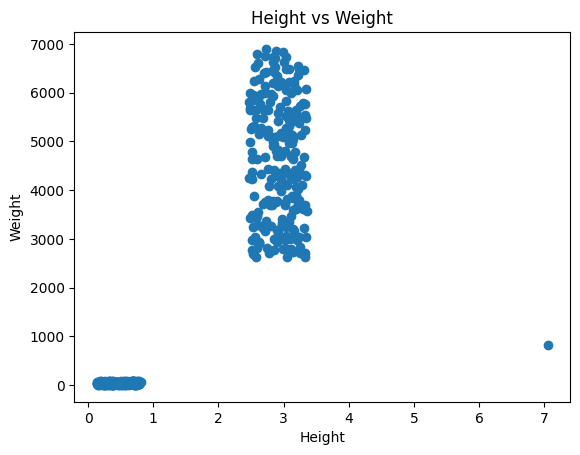

In [ ]:
plt.scatter(df_4legs['height'],df_4legs['weight'])  
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height vs Weight')
plt.show()

In [ ]:
# TODO: Create clusteing model to classify Dogs vs Elephants

# Set to 'elephant' if heavy
df.loc[(df['weight'] >= 1500) & (df['animal_type'].isnull()), 'animal_type'] = 'elephant'

# Set to 'dog' if light
df.loc[(df['weight'] < 1500) & (df['animal_type'].isnull()), 'animal_type'] = 'dog'

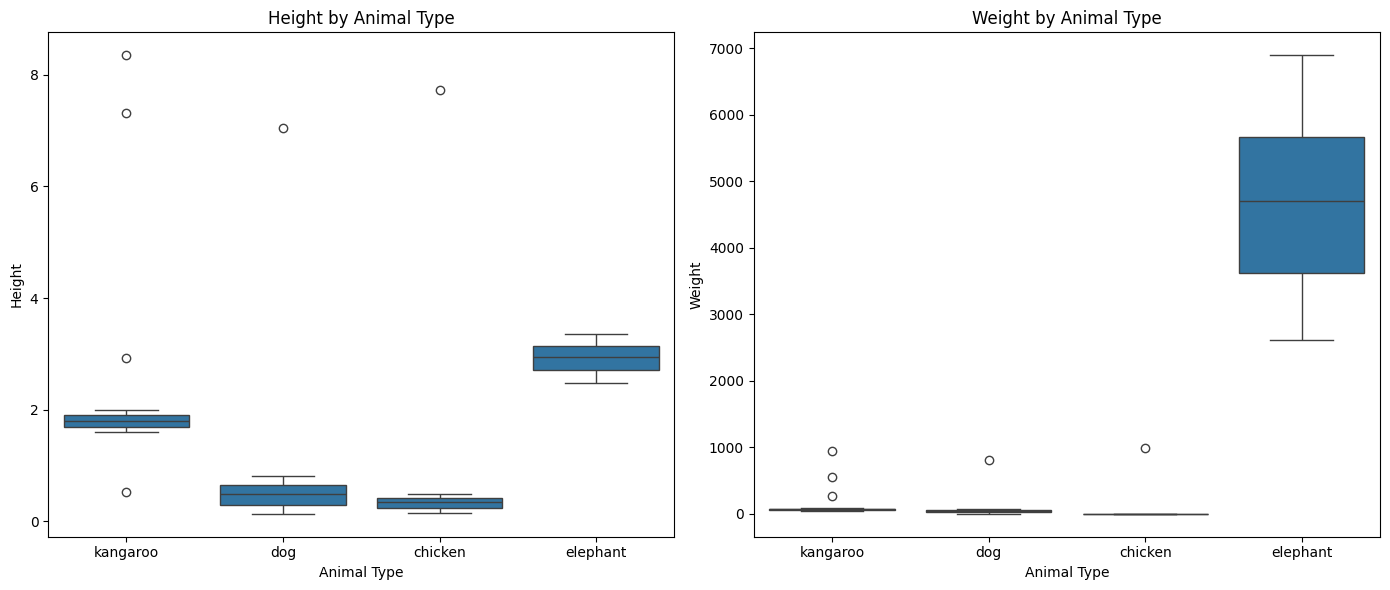

In [ ]:
# Plotting weight and height for each animal type
plt.figure(figsize=(14, 6))

# Boxplot for Height
plt.subplot(1, 2, 1)
sns.boxplot(x='animal_type', y='height', data=df)
plt.title('Height by Animal Type')
plt.xlabel('Animal Type')
plt.ylabel('Height')

# Boxplot for Weight
plt.subplot(1, 2, 2)
sns.boxplot(x='animal_type', y='weight', data=df)
plt.title('Weight by Animal Type')
plt.xlabel('Animal Type')
plt.ylabel('Weight')

plt.tight_layout()
plt.show()


In [ ]:
def remove_outliers_iqr(df):
    
    df_filtered = pd.DataFrame()
    cols_to_filter=['height', 'weight']

    for name, group in df.groupby('animal_type'):
        group_filtered = group.copy()
        for col in cols_to_filter:
            Q1 = group[col].quantile(0.25)
            Q3 = group[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            group_filtered = group_filtered[(group_filtered[col] >= lower) & (group_filtered[col] <= upper)]
        df_filtered = pd.concat([df_filtered, group_filtered], ignore_index=True)
    
    return df_filtered

df_cleaned = remove_outliers_iqr(df, )

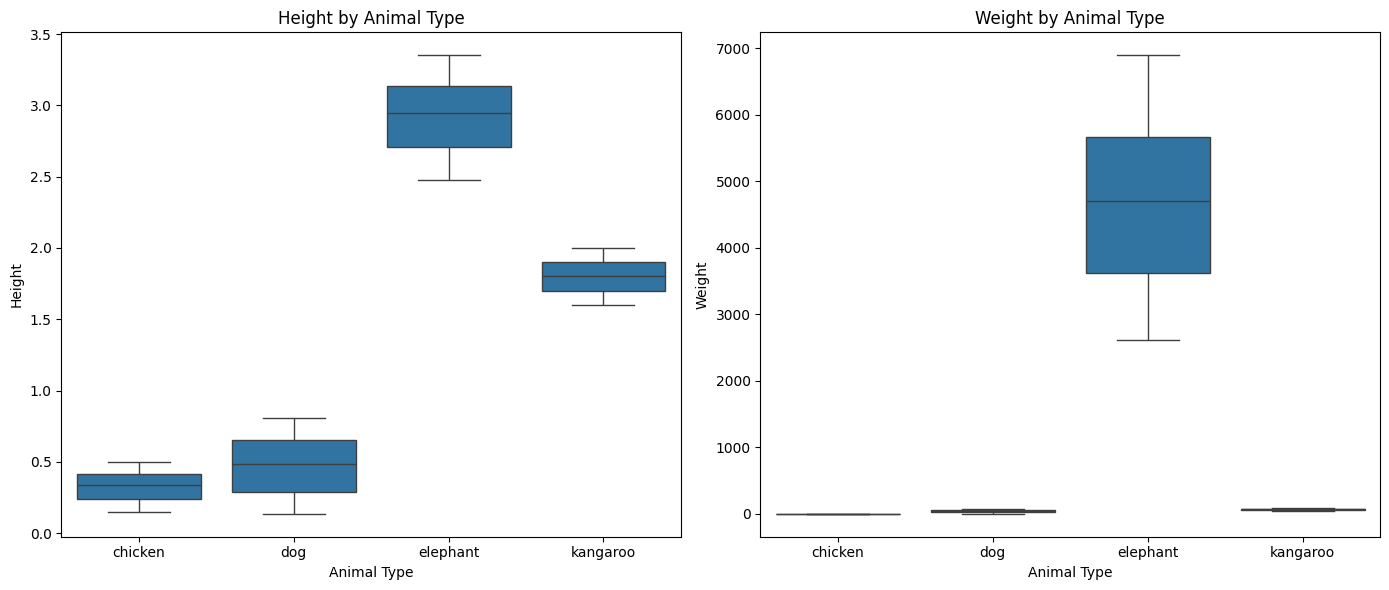

In [ ]:
# Plotting weight and height for each animal type
plt.figure(figsize=(14, 6))

# Boxplot for Height
plt.subplot(1, 2, 1)
sns.boxplot(x='animal_type', y='height', data=df_cleaned)
plt.title('Height by Animal Type')
plt.xlabel('Animal Type')
plt.ylabel('Height')

# Boxplot for Weight
plt.subplot(1, 2, 2)
sns.boxplot(x='animal_type', y='weight', data=df_cleaned)
plt.title('Weight by Animal Type')
plt.xlabel('Animal Type')
plt.ylabel('Weight')

plt.tight_layout()
plt.show()

In [ ]:
X = df_cleaned[['height', 'weight', 'walks_on_n_legs', 'has_wings', 'has_tail']]
y = df_cleaned['animal_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Save it to a file
joblib.dump(model, 'decision_tree_model.pkl')


NameError: name 'df_cleaned' is not defined